Pairs Trading

Pairs trading is a mean-reversion strategy that benefits from being market-neutral — it remains largely hedged against broad market movements. When implemented with rigorous statistical analysis, it can generate strong alpha (returns independent of the market).

At its core, pairs trading relies on identifying two securities, say X and Y, that share a strong economic or fundamental relationship — for example, companies in the same industry, supply chain, or sector. The idea is to model this relationship mathematically.

When the relative prices of these two securities diverge from their typical relationship (as measured by the model), the strategy takes positions expecting that they will revert to their historical equilibrium. This allows the trader to profit from temporary mispricings while maintaining a balanced exposure to the overall market.

In [53]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf

Cointegrated pairs found: [('AXISBANK.NS', 'SBIN.NS'), ('HDFCBANK.NS', 'KOTAKBANK.NS')]

Portfolio Metrics:
  annualized_return    : 0.1957
  annualized_vol       : 0.2653
  sharpe               : 0.4739
  max_drawdown         : -0.2707
  cagr                 : 0.1957
  risk_free_rate       : 0.0700
  excess_return        : 0.1257


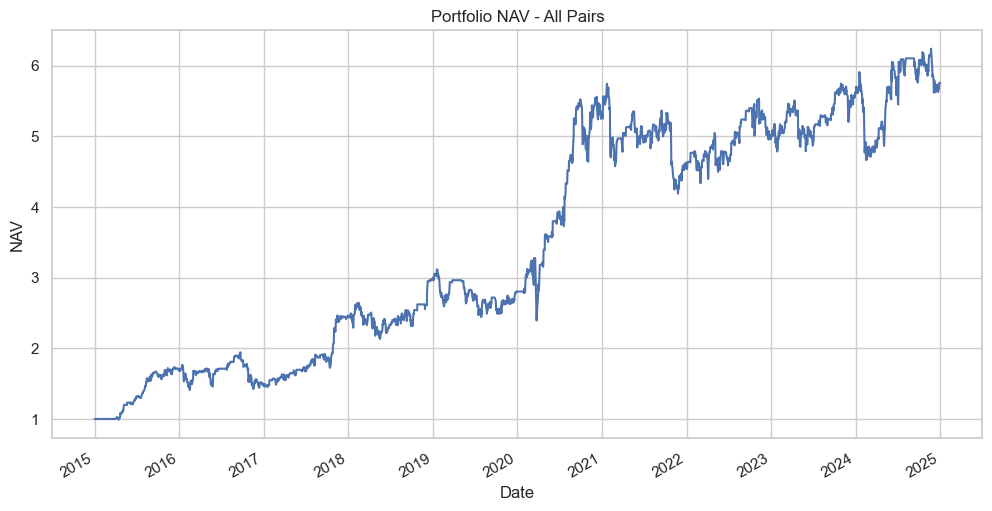

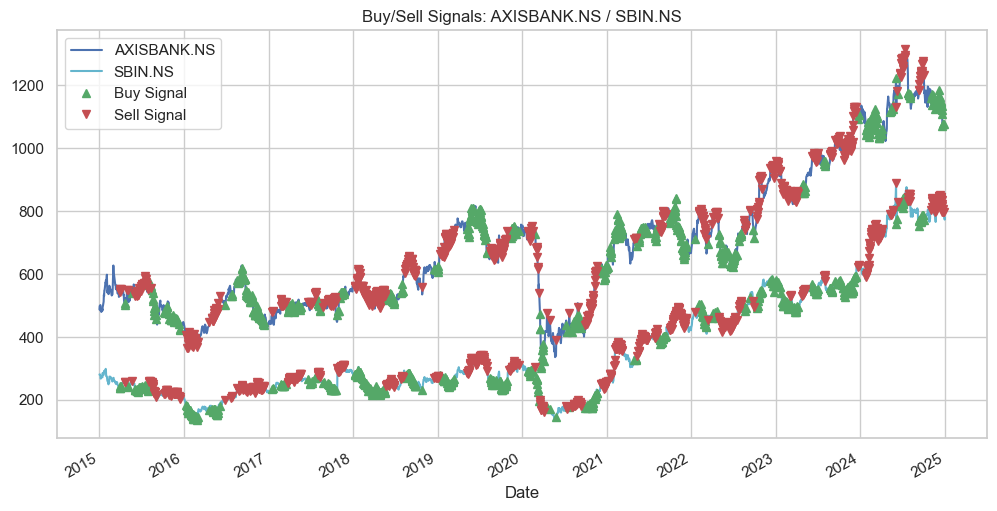

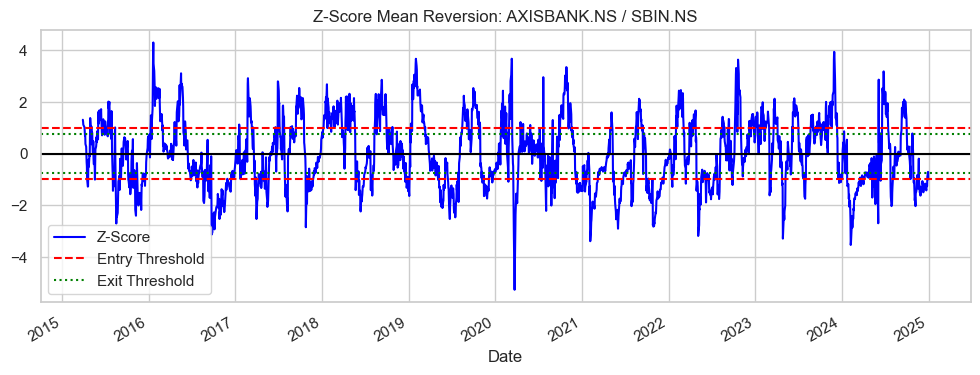

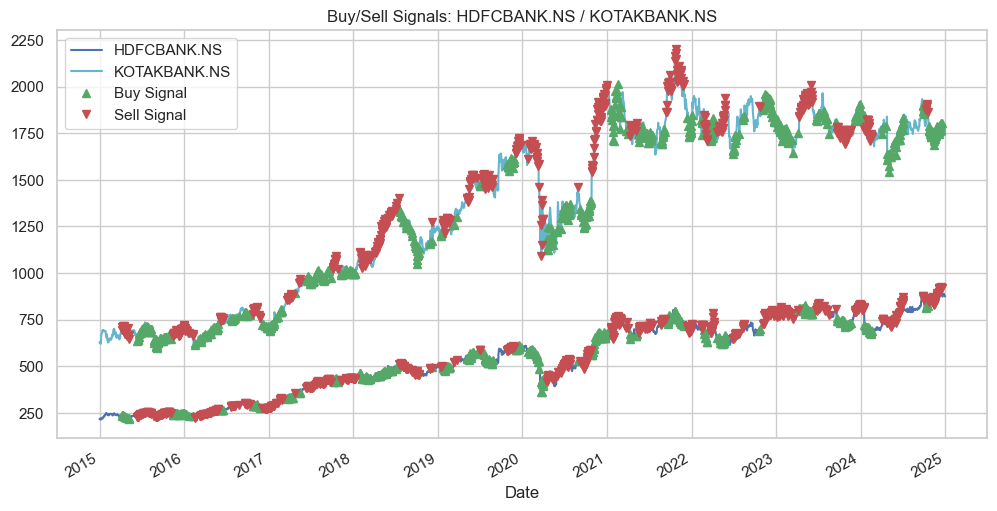

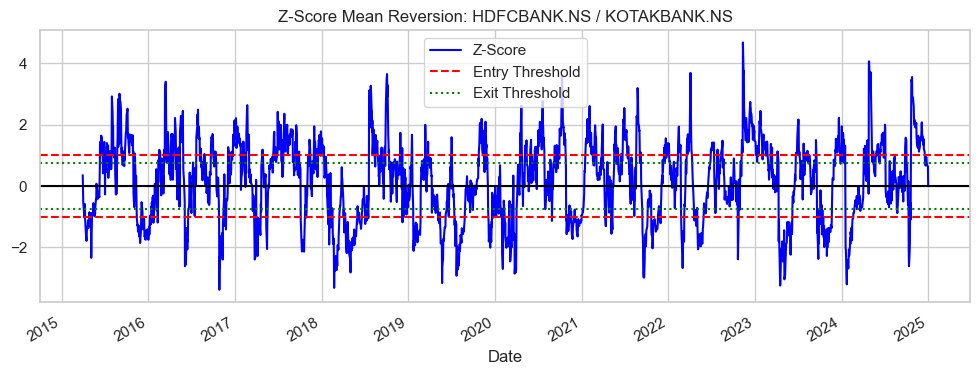

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint


# Data Utilities
def download_price_data(tickers, start, end, min_valid=0.95):
    """Download daily close prices and clean data."""
    data = yf.download(tickers, start=start, end=end, interval="1d",actions=False, progress=False, auto_adjust=True)['Close']
    data = data.dropna(axis=1, thresh=int(len(data) * min_valid))
    return data


# Statistical Utilities
def find_cointegrated_pairs(data, pvalue_threshold=0.05):
    """
    Identify cointegrated pairs among all combinations of assets.
    Returns list of (ticker1, ticker2).
    """
    n = data.shape[1]
    keys = data.columns
    pairs = []

    for i in range(n):
        for j in range(i + 1, n):
            S1, S2 = data[keys[i]], data[keys[j]]
            _, pvalue, _ = coint(S1, S2)
            if pvalue < pvalue_threshold:
                pairs.append((keys[i], keys[j]))
    return pairs


def zscore(series, window):
    """Compute rolling z-score."""
    return (series - series.rolling(window).mean()) / series.rolling(window).std()


def half_life(series):
    """Estimate mean reversion half-life."""
    delta = series.diff().dropna()
    lag = series.shift(1).dropna()
    beta = np.polyfit(lag, delta, 1)[0]
    hl = -np.log(2) / beta if beta != 0 else 1.0
    return max(int(hl), 1)


# Trading Signal Logic
def generate_signals(z, entry_z=1.0, exit_z=0.75):
    """Generate trading signals based on z-score thresholds."""
    signals = pd.Series(0, index=z.index)
    signals[z > entry_z] = -1   # short spread
    signals[z < -entry_z] = 1   # long spread
    signals[(z.abs() < exit_z)] = 0
    return signals.ffill().fillna(0)


# Performance Metrics
def compute_performance_metrics(pnl_series, capital=100000, risk_free_rate=0.07):
    """Compute key performance metrics."""
    daily_ret = pnl_series / capital
    n_days = len(daily_ret)

    ann_ret = np.prod(1 + daily_ret) ** (252.0 / n_days) - 1 if n_days > 0 else 0.0
    ann_vol = daily_ret.std() * np.sqrt(252)
    excess_ret = ann_ret - risk_free_rate
    sharpe = excess_ret / ann_vol if ann_vol != 0 else np.nan

    nav = (1 + daily_ret).cumprod()
    peak = nav.cummax()
    drawdown = (nav - peak) / peak
    max_dd = drawdown.min()
    cagr = (nav.iloc[-1]) ** (252.0 / n_days) - 1 if n_days > 0 else 0.0

    return {
        'annualized_return': ann_ret,
        'annualized_vol': ann_vol,
        'sharpe': sharpe,
        'max_drawdown': max_dd,
        'cagr': cagr,
        'risk_free_rate': risk_free_rate,
        'excess_return': excess_ret
    }


# Backtesting Engine
def backtest_ratio_pair(S1, S2, entry_z=1.0, exit_z=0.75,
                        tc=0.0005, slippage=0.0005,
                        notional=100000, trade_size_pct=1.0):
    """
    Backtest a single ratio pair using rolling z-score mean reversion.
    Returns PnL, NAV, signals, and z-score series.
    """
    ratio = S1 / S2
    hl = 60  # Fixed lookback window; could also use half_life(ratio - ratio.mean())
    z = zscore(ratio, hl)

    signals = generate_signals(z, entry_z, exit_z)
    pos_ratio = signals

    pos_S1 = pos_ratio * notional * trade_size_pct
    pos_S2 = -pos_ratio * notional * trade_size_pct

    returns = pd.DataFrame({
        'S1': S1.pct_change().fillna(0),
        'S2': S2.pct_change().fillna(0)
    })
    pnl = pos_S1.shift(1) * returns['S1'] + pos_S2.shift(1) * returns['S2']

    trades_S1 = pos_S1.diff().abs()
    trades_S2 = pos_S2.diff().abs()
    tc_costs = (trades_S1 + trades_S2) * (tc + slippage)
    net_pnl = pnl - tc_costs

    nav = (1 + net_pnl / notional).cumprod()
    metrics = compute_performance_metrics(net_pnl, notional)

    return net_pnl, nav, signals, z, metrics


# Portfolio Backtest
def backtest_portfolio(data, pairs, **kwargs):
    """Run backtest across all pairs and aggregate portfolio PnL."""
    portfolio_pnl = pd.Series(0, index=data.index)
    pair_results = {}

    for pair in pairs:
        S1, S2 = data[pair[0]], data[pair[1]]
        net_pnl, nav, signals, z, metrics = backtest_ratio_pair(S1, S2, **kwargs)
        portfolio_pnl = portfolio_pnl.add(net_pnl, fill_value=0)
        pair_results[pair] = {
            'net_pnl': net_pnl,
            'nav': nav,
            'signals': signals,
            'zscore': z,
            'metrics': metrics
        }

    portfolio_nav = (1 + portfolio_pnl / 100000).cumprod()
    portfolio_metrics = compute_performance_metrics(portfolio_pnl, 100000)
    return portfolio_pnl, portfolio_nav, portfolio_metrics, pair_results


# Visualization
def plot_portfolio_nav(portfolio_nav):
    plt.figure(figsize=(12, 6))
    portfolio_nav.plot()
    plt.title("Portfolio NAV - All Pairs")
    plt.xlabel("Date")
    plt.ylabel("NAV")
    plt.grid(True)
    plt.show()


def plot_mean_reversion(z, entry_z=1.0, exit_z=0.75, title="Z-Score Mean Reversion"):
    plt.figure(figsize=(12, 5))
    z.plot(color='blue', label='Z-Score')
    plt.axhline(entry_z, color='red', linestyle='--', label=f'+{entry_z}')
    plt.axhline(-entry_z, color='red', linestyle='--', label=f'-{entry_z}')
    plt.axhline(exit_z, color='green', linestyle=':', label=f'+{exit_z}')
    plt.axhline(-exit_z, color='green', linestyle=':', label=f'-{exit_z}')
    plt.axhline(0, color='black', linestyle='-')
    plt.title(title)
    plt.legend()
    plt.show()

###Code Execution
start, end = "2015-01-01", "2025-01-01"
tickers = [
    "HDFCBANK.NS", "ICICIBANK.NS", "AXISBANK.NS", "KOTAKBANK.NS",
    "SBIN.NS", "PNB.NS", "BANKBARODA.NS", "IDFCFIRSTB.NS",
    "INDUSINDBK.NS", "FEDERALBNK.NS", "RBLBANK.NS", "YESBANK.NS"
]

data = download_price_data(tickers, start, end)
pairs = find_cointegrated_pairs(data)
print("Cointegrated pairs found:", pairs)

portfolio_pnl, portfolio_nav, portfolio_metrics, pair_results = backtest_portfolio(data, pairs)
print("\nPortfolio Metrics:")
for k, v in portfolio_metrics.items():
    print(f"  {k:<20} : {v:.4f}")

plot_portfolio_nav(portfolio_nav)
# Plot buy/sell signals and Z-score for all pairs

for pair, results in pair_results.items():
    S1 = data[pair[0]]
    S2 = data[pair[1]]
    signals = results['signals']
    z = results['zscore']
    
    # Buy/sell markers
    buyR = pd.Series(np.nan, index=S1.index)
    sellR = pd.Series(np.nan, index=S1.index)
    buy_signals = signals > 0
    sell_signals = signals < 0
    
    buyR[buy_signals] = S1[buy_signals]
    sellR[buy_signals] = S2[buy_signals]
    buyR[sell_signals] = S2[sell_signals]
    sellR[sell_signals] = S1[sell_signals]
    
    # Plot price with signals
    plt.figure(figsize=(12,6))
    S1.plot(color='b', label=S1.name)
    S2.plot(color='c', label=S2.name)
    buyR.plot(color='g', linestyle='None', marker='^', label='Buy Signal')
    sellR.plot(color='r', linestyle='None', marker='v', label='Sell Signal')
    plt.title(f'Buy/Sell Signals: {pair[0]} / {pair[1]}')
    plt.legend()
    plt.show()
    
    # Plot Z-score mean-reversion
    plt.figure(figsize=(12,4))
    z.plot(color='blue', label='Z-Score')
    plt.axhline(1.0, color='red', linestyle='--', label='Entry Threshold')
    plt.axhline(-1.0, color='red', linestyle='--')
    plt.axhline(0.75, color='green', linestyle=':', label='Exit Threshold')
    plt.axhline(-0.75, color='green', linestyle=':')
    plt.axhline(0, color='black', linestyle='-')
    plt.title(f'Z-Score Mean Reversion: {pair[0]} / {pair[1]}')
    plt.legend()
    plt.show()

